['/data/maryam.sana/datazips/vimeo_septuplet/sequences/00075/0846/im1.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00075/0846/im2.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00075/0846/im3.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00075/0846/im4.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00075/0846/im5.png']
['/data/maryam.sana/datazips/vimeo_septuplet/sequences/00053/0127/im1.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00053/0127/im2.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00053/0127/im3.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00053/0127/im4.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00053/0127/im5.png']
['/data/maryam.sana/datazips/vimeo_septuplet/sequences/00085/0991/im1.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00085/0991/im2.png', '/data/maryam.sana/datazips/vimeo_septuplet/sequences/00085/0991/im3.png', '/data/maryam.sana/dat

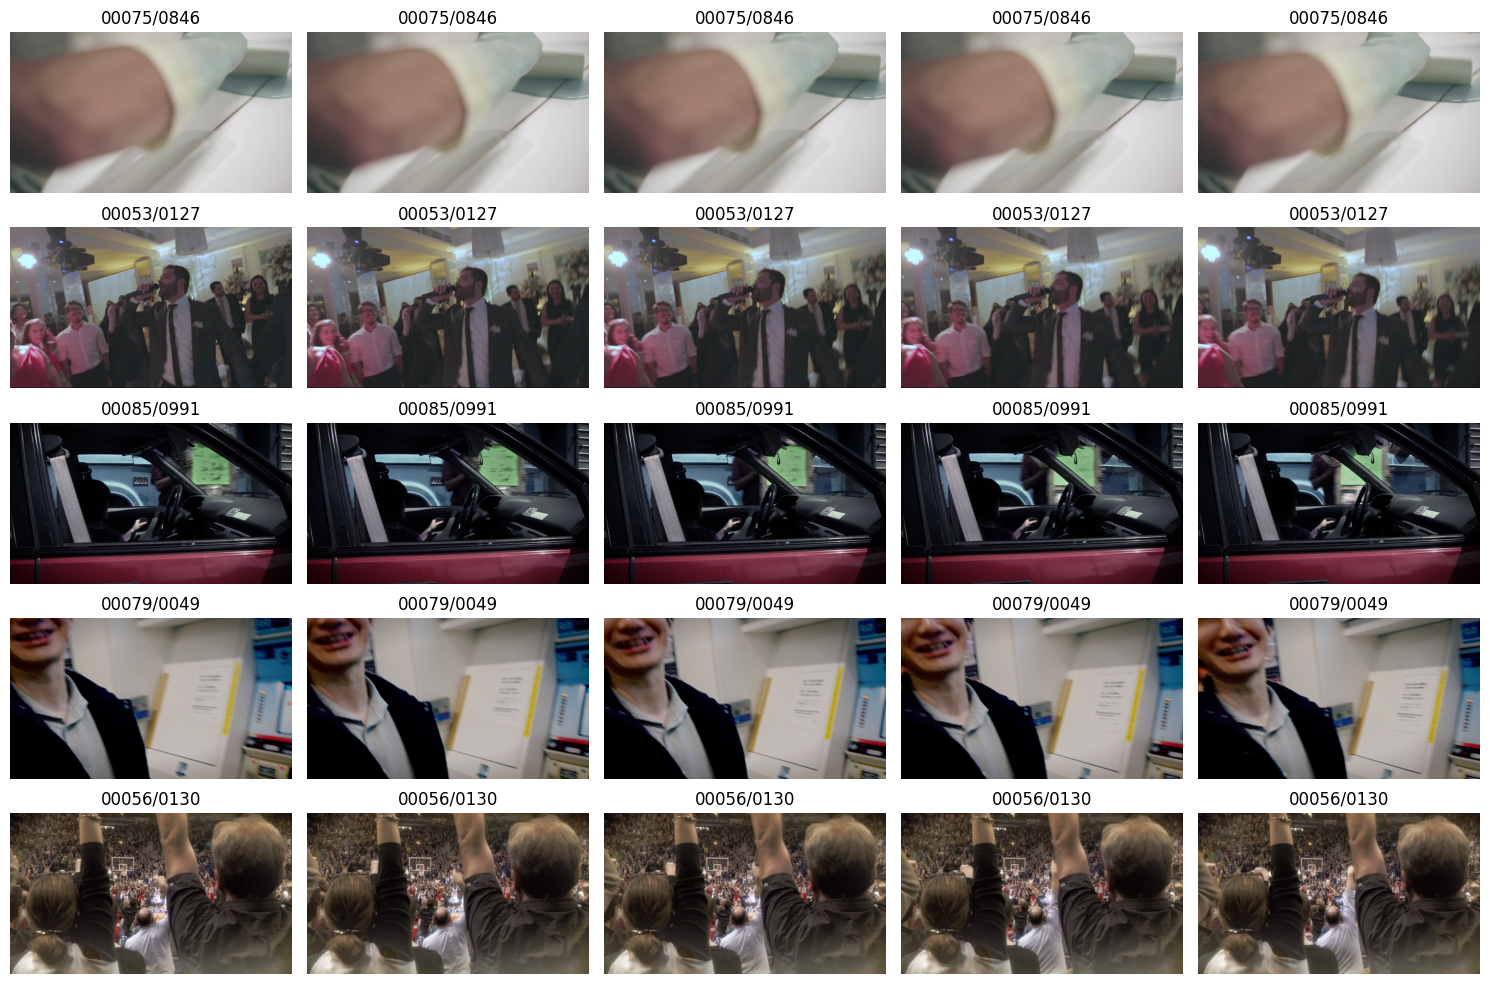

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# Set the path to the Vimeo dataset
dataset_path = "/data/maryam.sana/datazips/vimeo_septuplet/sequences/"

# Function to get list of video directories
def get_video_dirs(base_path):
    return sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

# Function to get list of sequence directories for a given video
def get_sequence_dirs(video_path):
    return sorted([d for d in os.listdir(video_path) if os.path.isdir(os.path.join(video_path, d))])

# Get the list of videos and sequences
video_dirs = get_video_dirs(dataset_path)

# Function to generate random video and sequence indices
def get_random_indices(video_dirs):
    video_dir = random.choice(video_dirs)
    video_path = os.path.join(dataset_path, video_dir)
    sequence_dirs = get_sequence_dirs(video_path)
    sequence_dir = random.choice(sequence_dirs)
    return video_dir, sequence_dir

# Function to get image paths for a given video and sequence
def get_image_paths(video_dir, sequence_dir):
    sequence_path = os.path.join(dataset_path, video_dir, sequence_dir)
    image_paths = [os.path.join(sequence_path, f"im{i}.png") for i in range(1, 6)]
    print(image_paths)
    return image_paths

# Pick 5 sequences randomly
random_sequences = [get_random_indices(video_dirs) for _ in range(5)]



# Plot the images
fig, axes = plt.subplots(5, 5, figsize=(15, 10))

for row, (video_dir, sequence_dir) in enumerate(random_sequences):
    image_paths = get_image_paths(video_dir, sequence_dir)
    for col, image_path in enumerate(image_paths):
        if os.path.exists(image_path):
            img = plt.imread(image_path)
            axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f"{video_dir}/{sequence_dir}")

plt.tight_layout()
plt.show()



In [2]:
import sys

if "./" not in sys.path:
    sys.path.append("./")
from utils.share import *
import utils.config as config

import einops
import gradio as gr
import numpy as np
import cv2
import torch
from pytorch_lightning import seed_everything

from annotator.util import resize_image, HWC3


from models.util import create_model, load_state_dict
from models.ddim_hacked import DDIMSampler


model = create_model("/data/maryam.sana/vimeo_unicontrol/Uni-ControlNet/configs/vimeo_img2img/uni_v15.yaml").cpu()
model.load_state_dict(load_state_dict("/data/maryam.sana/vimeo_unicontrol/Uni-ControlNet/checkpoints/vimeo_img2img/uni_v15.ckpt", location="cuda"))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

/data/maryam.sana/anaconda3/envs/unicontrol/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/maryam.sana/anaconda3/envs/unicontrol/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


logging improved.
Enabled sliced_attention.
UniControlNet: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEffic

In [3]:
def process(
    original_image,
    prompt,
    a_prompt,
    n_prompt,
    num_samples,
    image_resolution,
    ddim_steps,
    strength,
    scale,
    seed,
    eta,
    global_strength,
):

    seed_everything(seed)

    with torch.no_grad():
        original_image = resize_image(HWC3(original_image), image_resolution)

        H, W, C = original_image.shape

        content_emb = np.zeros((768))

        detected_maps = np.concatenate([original_image], axis=2)

        local_control = torch.from_numpy(detected_maps.copy()).float().cuda() / 255.0
        local_control = torch.stack([local_control for _ in range(num_samples)], dim=0)
        local_control = einops.rearrange(local_control, "b h w c -> b c h w").clone()
        global_control = torch.from_numpy(content_emb.copy()).float().cuda().clone()
        global_control = torch.stack(
            [global_control for _ in range(num_samples)], dim=0
        )

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        uc_local_control = local_control
        uc_global_control = torch.zeros_like(global_control)
        cond = {
            "local_control": [local_control],
            "c_crossattn": [
                model.get_learned_conditioning([prompt + ", " + a_prompt] * num_samples)
            ],
            "global_control": [global_control],
        }
        un_cond = {
            "local_control": [uc_local_control],
            "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)],
            "global_control": [uc_global_control],
        }
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength] * 13
        samples, _ = ddim_sampler.sample(
            ddim_steps,
            num_samples,
            shape,
            cond,
            verbose=True,
            eta=eta,
            unconditional_guidance_scale=scale,
            unconditional_conditioning=un_cond,
            global_strength=global_strength,
        )

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (
            (einops.rearrange(x_samples, "b c h w -> b h w c") * 127.5 + 127.5)
            .cpu()
            .numpy()
            .clip(0, 255)
            .astype(np.uint8)
        )
        results = [x_samples[i] for i in range(num_samples)]

    return (results, [original_image])


In [9]:
from PIL import Image
import numpy as np

a_prompt = "best quality, extremely detailed"
n_prompt = "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality"
num_samples = 1
image_resolution = 512
ddim_steps = 50
strength = 1
scale = 7.5
seed = 42
eta = 0.0
global_strength = 1

def get_recons_img(prompt, original_image, local_image):
    pred = process(local_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, strength, scale, seed, eta, global_strength)
    recons_img = pred[0][0]

    # Ensure the images are of the same size
    if original_image.shape != recons_img.shape:
        recons_img = cv2.resize(recons_img, (original_image.shape[1], original_image.shape[0]))

    # Calculate residue
    residue = original_image - recons_img

    return recons_img, residue

Global seed set to 42


Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.52153981 0.4881804  0.45523876 0.42288151 0.39126703 0.36

DDIM Sampler: 100%|████████████████████████████████████| 50/50 [00:18<00:00,  2.64it/s]
Global seed set to 42


Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.52153981 0.4881804  0.45523876 0.42288151 0.39126703 0.36

DDIM Sampler: 100%|████████████████████████████████████| 50/50 [00:19<00:00,  2.62it/s]
Global seed set to 42


Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.52153981 0.4881804  0.45523876 0.42288151 0.39126703 0.36

DDIM Sampler: 100%|████████████████████████████████████| 50/50 [00:19<00:00,  2.61it/s]
Global seed set to 42


Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.52153981 0.4881804  0.45523876 0.42288151 0.39126703 0.36

DDIM Sampler: 100%|████████████████████████████████████| 50/50 [00:19<00:00,  2.61it/s]
Global seed set to 42


Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.52153981 0.4881804  0.45523876 0.42288151 0.39126703 0.36

DDIM Sampler: 100%|████████████████████████████████████| 50/50 [00:19<00:00,  2.60it/s]
Global seed set to 42


Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.52153981 0.4881804  0.45523876 0.42288151 0.39126703 0.36

DDIM Sampler: 100%|████████████████████████████████████| 50/50 [00:19<00:00,  2.60it/s]
Global seed set to 42


Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.52153981 0.4881804  0.45523876 0.42288151 0.39126703 0.36

DDIM Sampler: 100%|████████████████████████████████████| 50/50 [00:19<00:00,  2.60it/s]


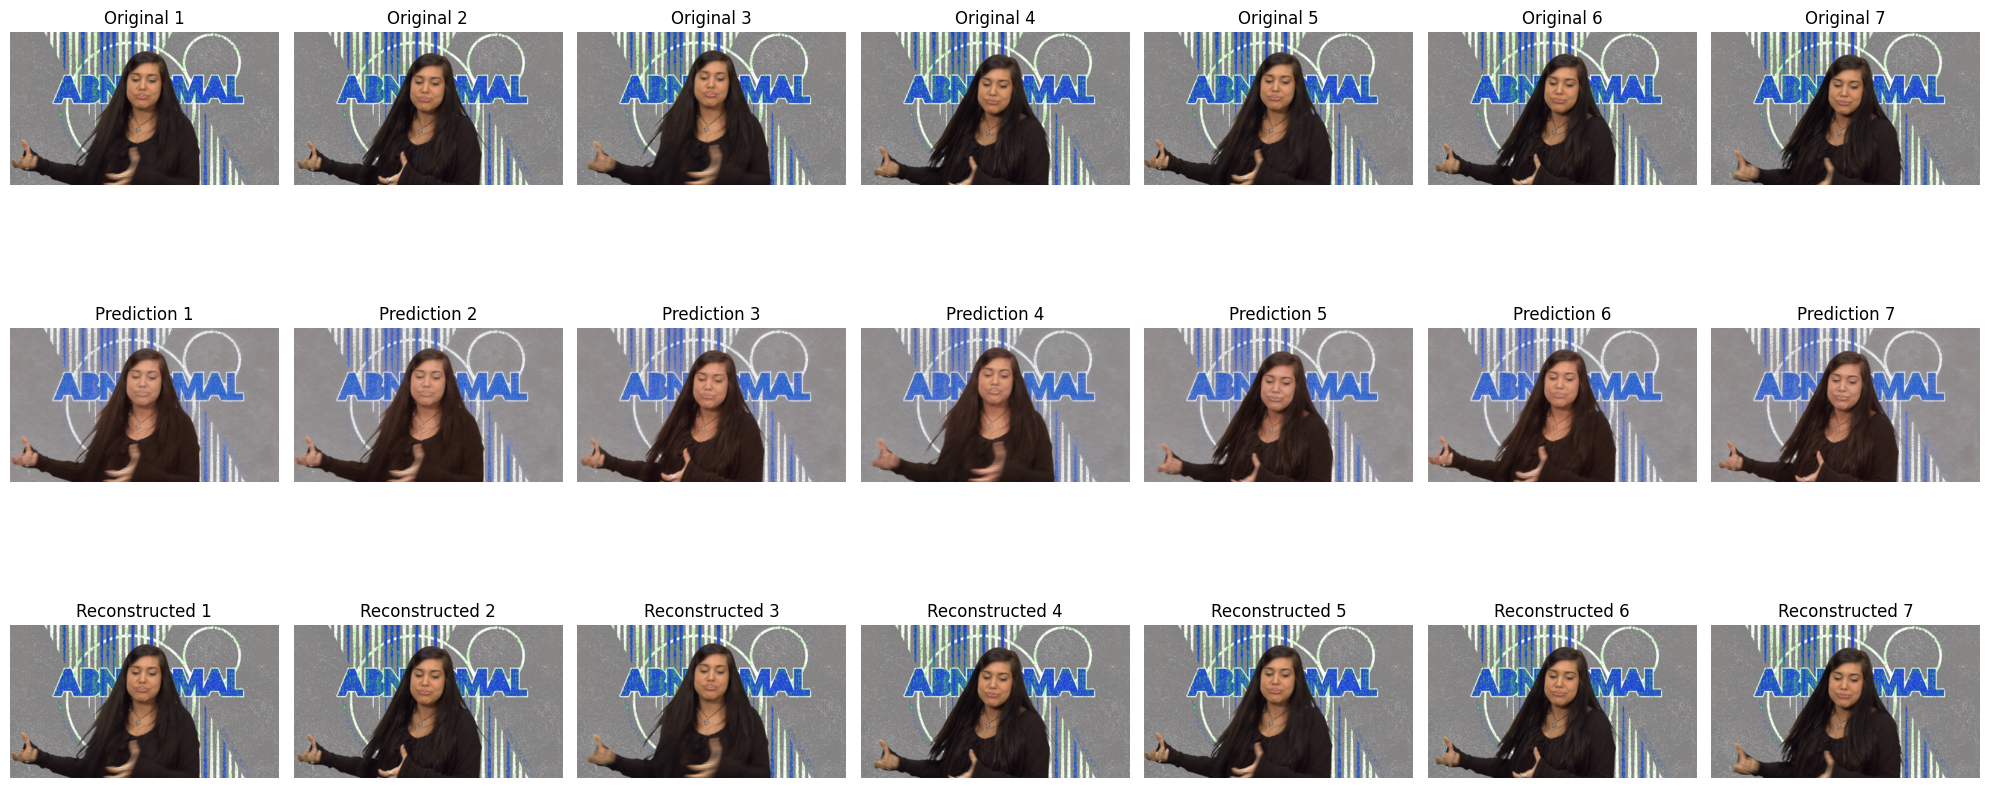

In [12]:
import glob

def main():

    # Pick a random video and sequence
    # video_dir, sequence_dir = get_random_indices(video_dirs)
    # image_paths = get_image_paths(video_dir, sequence_dir)
    image_paths = glob.glob('data/00096_0576/*')
    
    prompt = 'a girl with black hair and black shirt standing infront grey and blue background '

    original_images = [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in image_paths]

    reconstructed_images = []
    residues = []
    predictions = []
    for i, original_image in enumerate(original_images):
        if i == 0:
            pred_img, residue = get_recons_img(prompt, original_image,original_image)
        else:
            pred_img,residue = get_recons_img(prompt, original_image,reconstructed_images[-1])
        predictions.append(pred_img)
        residues.append(residue)
        reconstructed_images.append(pred_img + residue)

    # Plot the original and reconstructed images
    fig, axes = plt.subplots(3, len(original_images), figsize=(20, 10))
    for i in range(len(original_images)):
        axes[0, i].imshow(original_images[i])
        axes[0, i].set_title(f"Original {i + 1}")
        axes[0, i].axis('off')
        axes[1, i].imshow(predictions[i])
        axes[1, i].set_title(f"Prediction {i + 1}")
        axes[1, i].axis('off')
        axes[2, i].imshow(reconstructed_images[i])
        axes[2, i].set_title(f"Reconstructed {i + 1}")
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()